In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod.families import links
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
current_directory = os.getcwd()

In [3]:
taxi_data=pd.read_csv(os.path.join(current_directory, 'mex_clean.csv'))


First it is a good idea to explore the data

The kaggle page says that store_and_fwd_flag only has one value so its not helpfull

In [4]:
del taxi_data['store_and_fwd_flag'] #Removing this column since it only has one value

## Exploratory Analysis and data cleaning

In [5]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12694 entries, 0 to 12693
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12694 non-null  int64  
 1   vendor_id          12694 non-null  object 
 2   pickup_datetime    12694 non-null  object 
 3   dropoff_datetime   12694 non-null  object 
 4   pickup_longitude   12694 non-null  float64
 5   pickup_latitude    12694 non-null  float64
 6   dropoff_longitude  12694 non-null  float64
 7   dropoff_latitude   12694 non-null  float64
 8   trip_duration      12694 non-null  int64  
 9   dist_meters        12694 non-null  int64  
 10  wait_sec           12694 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 1.1+ MB


Change dates to datetime for easier usage

In [6]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

Check for na

In [7]:
cols_with_na = taxi_data.columns[taxi_data.isnull().any()].tolist()
print("List of columns with NA values:")
print(cols_with_na)
print("\n" + "="*30 + "\n")

List of columns with NA values:
[]




In [8]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
0,1,México DF Taxi de Sitio,2016-09-16 07:14:12,2016-09-18 04:41:40,-99.097369,19.416874,-99.202729,19.430353,120449,12373,242
1,2,México DF Taxi Libre,2016-09-18 06:16:33,2016-09-18 10:11:43,-99.297148,19.322128,-99.289949,19.326538,14110,1700,461
2,3,México DF Taxi Libre,2016-09-18 10:11:50,2016-09-18 10:23:11,-99.289603,19.326263,-99.271874,19.328530,681,2848,129
3,4,México DF Taxi Libre,2016-09-18 10:23:38,2016-09-18 10:30:53,-99.271161,19.328875,-99.279900,19.326256,436,1409,106
4,5,México DF Taxi Libre,2016-09-18 10:44:18,2016-09-18 10:51:40,-99.282761,19.326944,-99.291705,19.322754,442,1567,85


In [9]:
taxi_data.describe()

,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,12694.000000,12694,12694,12694.000000,12694.000000,12694.000000,12694.000000,1.269400e+04,12694.000000,1.269400e+04
mean,6347.500000,2017-02-15 21:21:51.969355520,2017-02-16 03:37:29.424058624,-99.136155,19.385067,-99.133728,19.386764,2.298377e+04,6666.431700,1.161270e+06
min,1.000000,2016-06-24 08:37:31,2016-06-24 11:05:35,-108.985069,18.829117,-108.987429,18.829103,2.000000e+00,21.000000,0.000000e+00
25%,3174.250000,2016-11-20 10:51:15.500000,2016-11-21 04:17:05.500000,-99.195615,19.325832,-99.192102,19.325325,4.840000e+02,1775.000000,8.900000e+01
50%,6347.500000,2017-02-22 08:39:17.500000,2017-02-22 10:36:01,-99.164436,19.371382,-99.160705,19.374913,1.033500e+03,3948.000000,2.340000e+02
75%,9520.750000,2017-05-29 09:29:58.750000128,2017-05-30 01:42:57,-99.107092,19.432106,-99.107355,19.434360,2.368750e+03,8265.000000,5.910000e+02
max,12694.000000,2017-07-20 12:52:00,2017-07-20 12:53:21,-86.871347,25.752964,-86.871002,25.781058,1.657095e+07,802537.000000,4.429346e+09
std,3664.586493,NaN,NaN,0.430001,0.129518,0.429582,0.131199,2.293364e+05,11386.891512,5.799612e+07


In [10]:
taxi_data[taxi_data['dist_meters']==max(taxi_data['dist_meters'])]

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
7467,7468,México DF Taxi de Sitio,2017-02-05 01:16:12,2017-02-05 01:41:35,-99.038495,19.592712,-99.032371,19.528059,1524,802537,247


apparently there is a trip that took 139 years to complete, one that took 0 seconds and a trip that is 802 Km in just 25 minutes. There are certainly some erroneous data points that need cleaning.

In [11]:
taxi_data['avg_speed'] = taxi_data['dist_meters']*3.6 / taxi_data['trip_duration']  # km/hr

clean_data_mask = (taxi_data['trip_duration'].between(30, 2*3600) & #only consider trip durations between 30 seconds and 2 hours
                   taxi_data['wait_sec'].between(0, 3600) &#only consider eait times between 0 seconds and 1 hour
                   taxi_data['dist_meters'].between(50, 40*1000) & # only consider trips between 50 mts and 30 km
                   taxi_data['avg_speed'].between(3, 120)) #only consider trips which average speed is between 3km/h and 120 km/h
taxi_data = taxi_data[clean_data_mask]


The difference between drop off and pick up should not be too far from the trip duration

In [12]:
taxi_data = taxi_data[
    np.abs((taxi_data['dropoff_datetime'] - taxi_data['pickup_datetime']).dt.total_seconds() - taxi_data['trip_duration']) < 180
]

In [13]:
taxi_data.describe()

,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,avg_speed
count,9654.000000,9654,9654,9654.000000,9654.000000,9654.000000,9654.000000,9654.000000,9654.000000,9654.000000,9654.000000
mean,6460.053346,2017-02-18 04:41:10.509737216,2017-02-18 05:01:47.457116160,-99.141722,19.381862,-99.139471,19.383515,1237.448830,5699.146675,398.315724,17.936212
min,3.000000,2016-06-24 11:05:38,2016-06-24 11:06:15,-108.985069,19.178420,-108.987429,19.177652,30.000000,50.000000,0.000000,3.001947
25%,3288.250000,2016-11-22 08:37:28.500000,2016-11-22 09:23:32.750000128,-99.196318,19.324309,-99.194045,19.324194,474.000000,2025.250000,87.000000,12.002946
50%,6501.500000,2017-02-27 07:05:30,2017-02-27 07:49:05,-99.168314,19.370683,-99.162274,19.374565,880.500000,3906.000000,213.000000,16.594633
75%,9697.750000,2017-06-03 11:43:56.500000,2017-06-03 12:20:30.750000128,-99.106287,19.433176,-99.107647,19.434650,1581.000000,7440.500000,481.750000,21.862835
max,12692.000000,2017-07-20 12:52:00,2017-07-20 12:53:21,-86.871347,25.752964,-86.871002,25.781058,7165.000000,38696.000000,3593.000000,117.635294
std,3664.151081,NaN,NaN,0.378815,0.114019,0.378842,0.115389,1138.856731,5487.360187,518.788463,9.407034


In [14]:
def plot_distance_duration_scatterplot(df, dist_column='dist_meters', duration_column='trip_duration'):
    # Create the scatterplot
    fig = px.scatter(df,
                     x=dist_column,
                     y=duration_column,
                     title=f'Trip Duration vs. Distance Traveled',
                     labels={dist_column: 'Distance (meters)', duration_column: 'Trip Duration (seconds)'},
                     hover_data=[dist_column, duration_column] 
                    )

    fig.update_traces(marker=dict(size=5, opacity=0.6)) #lower opacity to be able to see high concentrations of points
    fig.update_layout(xaxis_title_text='Distance (meters)',
                      yaxis_title_text='Trip Duration (seconds)',
                      hovermode='closest'
                     )

    fig.show()

Distance is one of the most obvious variables to predict trip duration since triups over longer distances tend to last longer. So its important to understand how these two variables interact.

In [15]:
plot_distance_duration_scatterplot(taxi_data)

plotting the distribution of trip_duration

In [16]:
def plot_trip_duration_histogram(df: pd.DataFrame, title: str = "Distribution of Trip Duration"):
    plt.figure(figsize=(10, 6)) 
    sns.histplot(df['trip_duration'], kde=True, bins=50, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel('Trip Duration', fontsize=12)
    plt.ylabel('Frequency / Density', fontsize=12)
    plt.grid(axis='y', alpha=0.75)

    plt.show()

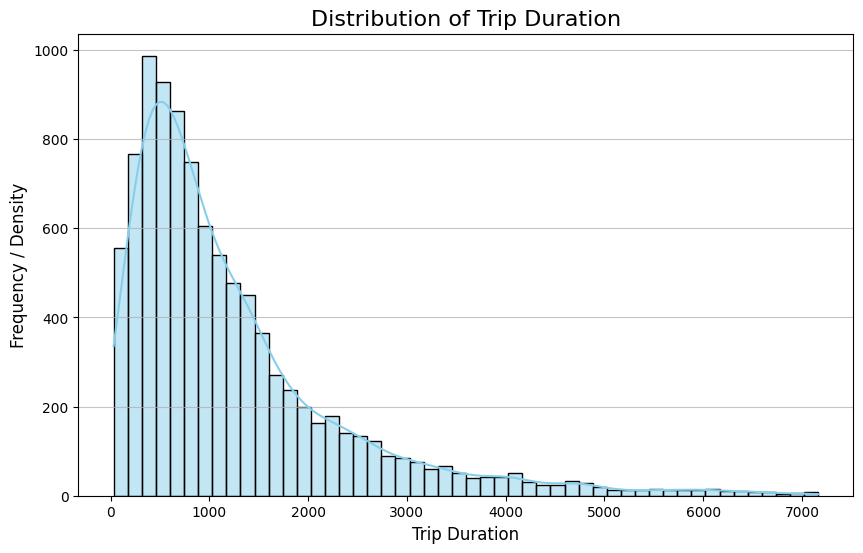

In [17]:
plot_trip_duration_histogram(taxi_data)

We can observe that most of the trips are short and the distribution is right skewed

Now, we will create features that will be helpful for the mode, like an hour of day variable and a day of the week one and month

In [18]:
print(taxi_data.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'dist_meters', 'wait_sec',
       'avg_speed'],
      dtype='object')


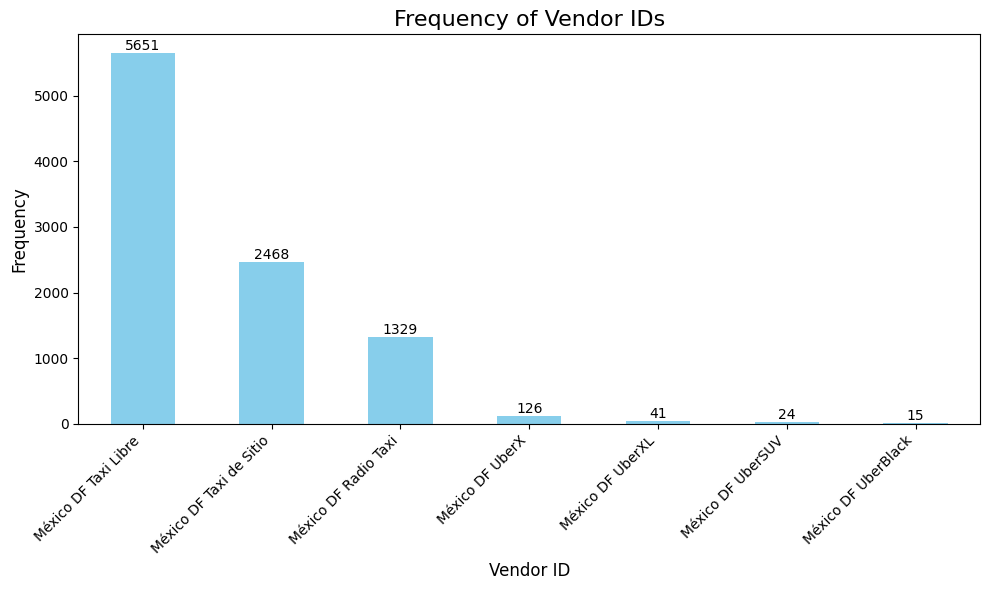

In [19]:
vendor_counts = taxi_data['vendor_id'].value_counts()
plt.figure(figsize=(10, 6)) 
vendor_counts.plot(kind='bar', color='skyblue')

plt.title('Frequency of Vendor IDs', fontsize=16)
plt.xlabel('Vendor ID', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(rotation=45, ha='right')

for index, value in enumerate(vendor_counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.tight_layout()

plt.show()

Clearly there are 3 main vendors. Its a good idea to exclude the Uber vendors since they are a small sample and could bring a lot of noise to the models. 

In [20]:
taxi_data['vendor_id'].unique()

array(['México DF Taxi Libre', 'México DF Radio Taxi',
       'México DF Taxi de Sitio', 'México DF UberX', 'México DF UberSUV',
       'México DF UberBlack', 'México DF UberXL'], dtype=object)

In [21]:
list_of_vendors = ['México DF Taxi Libre','México DF Radio Taxi','México DF Taxi de Sitio']
taxi_data = taxi_data[taxi_data['vendor_id'].isin(list_of_vendors)]

Create a map to see a sample of the trips

In [51]:
random.seed(42)
df = taxi_data.sample(n=200)
pickup_df = df[['pickup_latitude', 'pickup_longitude', 'id']].copy()
pickup_df.columns = ['latitude', 'longitude', 'id']
pickup_df['location_type'] = 'Pickup'

dropoff_df = df[['dropoff_latitude', 'dropoff_longitude', 'id']].copy()
dropoff_df.columns = ['latitude', 'longitude', 'id']
dropoff_df['location_type'] = 'Dropoff'

all_locations_df = pd.concat([pickup_df, dropoff_df])

fig = px.scatter_mapbox(all_locations_df,
                        lat="latitude",
                        lon="longitude",
                        color="location_type", # Color based on 'Pickup' or 'Dropoff'
                        hover_name="id",
                        hover_data={"latitude": True, "longitude": True, "location_type": True},
                        zoom=10,
                        height=600,
                        width=600,
                        title="Pickup and Dropoff Locations")

fig.update_layout(mapbox_style="open-street-map") # Use OpenStreetMap tiles
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_traces(marker=dict(size=12))

# Add lines connecting pickup and dropoff for each trip
for index, row in df.iterrows():
    fig.add_trace(
        go.Scattermapbox(
            mode="lines",
            lat=[row['pickup_latitude'], row['dropoff_latitude']],
            lon=[row['pickup_longitude'], row['dropoff_longitude']],
            line=dict(color='black', width=1), 
            name=f"Trip {row['id']}", 
            showlegend=False 
        )
    )



fig.show()

C:\Users\aarriaga\AppData\Local\Temp\ipykernel_26120\3953979145.py:13: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\aarriaga\AppData\Local\Temp\ipykernel_26120\3953979145.py:31: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



## FEATURE ENGINEERING

In [23]:
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.day_name()
taxi_data['pickup_month'] = taxi_data['pickup_datetime'].dt.month_name()

 A simple and fast way to decide when traffic is happening is to take the median of the average speeds by hour and day of the week.

In [24]:
taxi_data['average_speed'] = taxi_data['dist_meters']*3.6 /  (taxi_data['trip_duration'])

In [25]:
#Split the data between train and test, using a fixed seed
#We will focus on using the X_train to create the new variables simulating a real scenario
X_train, X_test, y_train, y_test = train_test_split(taxi_data.drop(columns=['trip_duration']), taxi_data.loc[:,'trip_duration'], test_size=0.2, random_state=42)

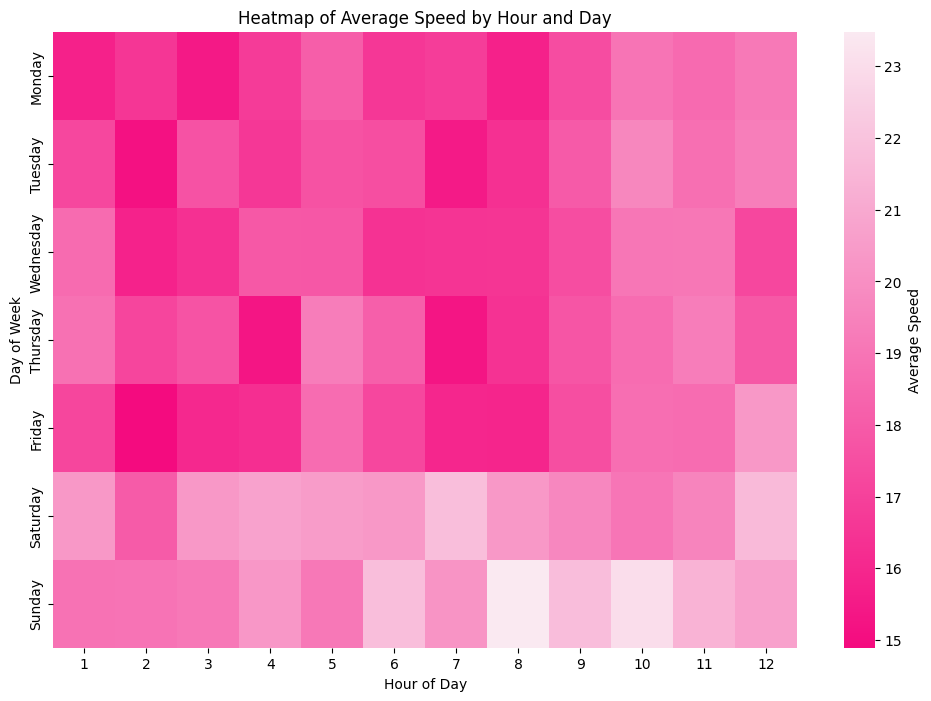

In [26]:
#creation of  a heatmap that will show us when there is more traffic, i.e. lowest average speed
hour_day_avg_speed = X_train.groupby(['pickup_day_of_week', 'pickup_hour'])['average_speed'].mean().reset_index()
red_to_pink_colormap = LinearSegmentedColormap.from_list("pink_purple", ["#F40B7F", "#FAE9F1"])
heatmap_data = hour_day_avg_speed.pivot(index='pickup_day_of_week', columns='pickup_hour', values='average_speed')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

heatmap_data = heatmap_data.reindex(day_order)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap=red_to_pink_colormap, cbar_kws={'label': 'Average Speed'})
plt.title('Heatmap of Average Speed by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

the plot makes sense,weekends seem to be the days with least activity. But it also shows a limitation of the data, the hours only go in a range of 1 to 12 and checking the data there is no am or pm distinction, but looking at the speed it still might be useful to use days of the week with high traffic.

In [27]:
X_train['pickup_hour'].unique()

array([ 7, 10,  4,  8,  6, 12,  9,  1,  5,  2, 11,  3])

In [28]:
#calculate average speed by hour of day to then select the median to discriminate between traffic levels
hourly_avg_speeds = {}

for hour in range(1,12):
    taxi_trips_by_hour =X_train[X_train['pickup_hour'] == hour]
    hourly_avg_speeds[hour] = taxi_trips_by_hour['average_speed'].mean()

# Convert dictionary to DataFrame for better readability
hourly_avg_speed_df = pd.DataFrame(list(hourly_avg_speeds.items()), columns=['hour', 'average_speed'])

median_speed_hourly = hourly_avg_speed_df['average_speed'].median()

# Create a dictionary mapping hour to traffic level based on average speed
hour_to_traffic = {
    row['hour']: 1 if row['average_speed'] > median_speed_hourly else 0
    for _, row in hourly_avg_speed_df.iterrows()
}

# Create a new column 'traffic_hour' based on the pickup hour
X_train['traffic_hour'] = X_train['pickup_hour'].map(hour_to_traffic)
X_test['traffic_hour'] = X_test['pickup_hour'].map(hour_to_traffic)

In [29]:
#calculate average speed by day of the week to then select the median to discriminate between traffic levels
day_of_week_avg_speed = X_train.groupby('pickup_day_of_week')['average_speed'].mean().reset_index()
day_of_week_avg_speed.columns = ['pick_up_day_of_week', 'average_speed']
median_speed_daily = day_of_week_avg_speed['average_speed'].median()

# Create a dictionary mapping day of the week to traffic level
day_to_traffic = {
    row['pick_up_day_of_week']: 1 if row['average_speed'] > median_speed_daily else 0
    for _, row in day_of_week_avg_speed.iterrows()
}

# Create a new column 'traffic_day' based on the day of the week
X_train['traffic_day'] = X_train['pickup_day_of_week'].map(day_to_traffic)
X_test['traffic_day'] = X_test['pickup_day_of_week'].map(day_to_traffic)

Apart from using latitude and longitude in the model, its a better idea to also use the distances between the pickup and dropoff as calculated with manhattan distances

In [30]:
#functions that will help calcualte the manhattan distance for each trip
def haversine(lat1, lng1, lat2, lng2):
    """haversine distance is used in the calculation for manhattan distance
    this first calculates the distance between two points in a sphere"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance(lat1, lng1, lat2, lng2):
    """manhatten distance: 
    uses the calculations of the harvestine distance to calculate a gridlike pattern of movement"""
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

In [31]:
#create a column with the manhattan distance in the dataframe
X_train.loc[:,'manhattan_distance'] = manhattan_distance(X_train['pickup_latitude'].values, 
                                                           X_train['pickup_longitude'].values, 
                                                           X_train['dropoff_latitude'].values, 
                                                           X_train['dropoff_longitude'].values)
X_test.loc[:,'manhattan_distance'] = manhattan_distance(X_test['pickup_latitude'].values, 
                                                           X_test['pickup_longitude'].values, 
                                                           X_test['dropoff_latitude'].values, 
                                                           X_test['dropoff_longitude'].values)

Lets create a grid of the city to create different zones for pickups and frop offs

In [32]:
def create_grid_zone_mapper(X_train, n_lat_bins=10, n_lon_bins=10):
    """
    Create grid zone mapper based on training data boundaries
    """
    # Define bin edges based on training data
    lat_min, lat_max = X_train['pickup_latitude'].min(), X_train['pickup_latitude'].max()
    lon_min, lon_max = X_train['pickup_longitude'].min(), X_train['pickup_longitude'].max()
    
    lat_edges = np.linspace(lat_min, lat_max, n_lat_bins + 1)
    lon_edges = np.linspace(lon_min, lon_max, n_lon_bins + 1)
    
    def assign_zones(df):
        """Apply grid zones to any dataframe"""
        # Use pd.cut with the predefined edges
        lat_bins = pd.cut(df['pickup_latitude'], bins=lat_edges, labels=False, include_lowest=True)
        lon_bins = pd.cut(df['pickup_longitude'], bins=lon_edges, labels=False, include_lowest=True)
        pickup_zones = lat_bins * n_lon_bins + lon_bins
        
        lat_bins_drop = pd.cut(df['dropoff_latitude'], bins=lat_edges, labels=False, include_lowest=True)
        lon_bins_drop = pd.cut(df['dropoff_longitude'], bins=lon_edges, labels=False, include_lowest=True)
        dropoff_zones = lat_bins_drop * n_lon_bins + lon_bins_drop
        
        return pickup_zones, dropoff_zones
    
    return assign_zones, (lat_edges, lon_edges)

In [33]:
#Create the mapper from training data
zone_mapper, zone_info = create_grid_zone_mapper(X_train, n_lat_bins=12, n_lon_bins=12)
#Apply to training data
X_train['pickup_zone'], X_train['dropoff_zone'] = zone_mapper(X_train)

#Apply same zones to test data
X_test['pickup_zone'], X_test['dropoff_zone'] = zone_mapper(X_test)

# Handle any out-of-bounds points in test data (fill with a special "unknown" zone)
X_test['pickup_zone'] = X_test['pickup_zone'].fillna(-1)  # -1 for "outside training area"
X_test['dropoff_zone'] = X_test['dropoff_zone'].fillna(-1)

In [34]:
#One hot encoding categorical variables and scaling numerical variables that will be used in the models.
categorical_features = ['pickup_day_of_week', 'pickup_month','traffic_day','pickup_zone','dropoff_zone']
numerical_features = ['dist_meters', 'wait_sec','manhattan_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep any other columns if they exist
)

In [35]:
#defines the columns that will be used to create X 
features = [
    'dist_meters',
    'wait_sec',
    'pickup_day_of_week',
    'pickup_month',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'traffic_day',
    'manhattan_distance',
    'pickup_zone',
    'dropoff_zone'
]
X_train = X_train[features]
X_test = X_test[features]

In [36]:
results = {} # Dictionary to store evaluation metrics for each model

# Helper function to evaluate and store metrics
def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results[model_name] = {'R-squared': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    print(f"\n--- {model_name} Results ---")
    print(f"R-squared: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

RIDGE

In [37]:
#Defining Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.1, random_state=42,max_iter=2000)) 
])
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
evaluate_model('Ridge Regression', y_test, y_pred_ridge)


--- Ridge Regression Results ---
R-squared: 0.6681
MAE: 343.4940
MSE: 416362.6755
RMSE: 645.2617


In [38]:
#Defining lassso regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=2000)) 
])
lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
evaluate_model('Lasso Regression', y_test, y_pred_lasso)


--- Lasso Regression Results ---
R-squared: 0.6676
MAE: 343.5470
MSE: 417023.0134
RMSE: 645.7732


In [39]:
#Defining a Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
evaluate_model('Random Forest', y_test, y_pred_rf)


--- Random Forest Results ---
R-squared: 0.6948
MAE: 320.0677
MSE: 382844.4955
RMSE: 618.7443


In [40]:
#Defining an XGBRegressor 
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
evaluate_model('XGBoost', y_test, y_pred_xgb)


--- XGBoost Results ---
R-squared: 0.6843
MAE: 327.3342
MSE: 396037.8125
RMSE: 629.3154


In [41]:
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn = preprocessor.transform(X_test)

#Defining a neural network with 3 hidden layers and one output iwth dropout to prevent overfitting
input_shape = X_train_nn.shape[1]

nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1) 
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\aarriaga\Documents\Codigos\data games\tensorflow\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [42]:
#Fitiing the nn 
random.seed(42)
history = nn_model.fit(X_train_nn, y_train,
                       epochs=100,
                       batch_size=64,
                       validation_split=0.1,
                       verbose=0) 



In [43]:
# Predict on the test set
y_pred_nn = nn_model.predict(X_test_nn).flatten() # flatten since predict returns a 2D array
evaluate_model('Neural Network', y_test, y_pred_nn)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

--- Neural Network Results ---
R-squared: 0.6801
MAE: 341.5839
MSE: 401298.9062
RMSE: 633.4816


In [44]:
#printing the results to find the best model
print("\n--- Summary of All Model Results ---")
results_df = pd.DataFrame(results).T
print(results_df.round(3))


--- Summary of All Model Results ---
                  R-squared      MAE         MSE     RMSE
Ridge Regression      0.668  343.494  416362.676  645.262
Lasso Regression      0.668  343.547  417023.013  645.773
Random Forest         0.695  320.068  382844.496  618.744
XGBoost               0.684  327.334  396037.812  629.315
Neural Network        0.680  341.584  401298.906  633.482


Lets see how much will it take me to go to work

Prediction without high traffic

In [45]:
new_entry_data = pd.DataFrame([{
    'vendor_id': 'México DF Taxi Libre',
    'dist_meters': 13200,
    'wait_sec': 120,
    'pickup_latitude': 19.348708, 
    'pickup_longitude': -99.184903,
    'dropoff_latitude': 19.426572, 
    'dropoff_longitude': -99.196754, 
    'pickup_day_of_week': str(3), # Wednesday
    'pickup_month': str(6), # June
    'traffic_day':1
}])
new_entry_data['manhattan_distance'] = manhattan_distance(new_entry_data['pickup_latitude'], 
                                                           new_entry_data['pickup_longitude'], 
                                                           new_entry_data['dropoff_latitude'], 
                                                           new_entry_data['dropoff_longitude'])
new_entry_data['pickup_zone'],new_entry_data['dropoff_zone']=zone_mapper(new_entry_data)

In [46]:
ridge_new_pred = ridge_pipeline.predict(new_entry_data)[0]
print(f"Ridge Regression Prediction: {ridge_new_pred:.4f}")

# Lasso Regression Prediction
lasso_new_pred = lasso_pipeline.predict(new_entry_data)[0]
print(f"Lasso Regression Prediction: {lasso_new_pred:.4f}")

# Random Forest Prediction
rf_new_pred = rf_pipeline.predict(new_entry_data)[0]
print(f"Random Forest Prediction: {rf_new_pred:.4f}")

# XGBoost Prediction
xgb_new_pred = xgb_pipeline.predict(new_entry_data)[0]
print(f"XGBoost Prediction: {xgb_new_pred:.4f}")

# Neural Network Prediction
new_entry_nn = preprocessor.transform(new_entry_data)
nn_new_pred = nn_model.predict(new_entry_nn).flatten()[0]
print(f"Neural Network Prediction: {nn_new_pred:.4f}")

Ridge Regression Prediction: 1760.9704
Lasso Regression Prediction: 1821.2230


Random Forest Prediction: 1491.2200
XGBoost Prediction: 1490.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Neural Network Prediction: 1268.1257


Prediction with high traffic

In [47]:
new_entry_data['traffic_day']=0

In [48]:
ridge_new_pred = ridge_pipeline.predict(new_entry_data)[0]
print(f"Ridge Regression Prediction: {ridge_new_pred:.4f}")

# Lasso Regression Prediction
lasso_new_pred = lasso_pipeline.predict(new_entry_data)[0]
print(f"Lasso Regression Prediction: {lasso_new_pred:.4f}")

# Random Forest Prediction
rf_new_pred = rf_pipeline.predict(new_entry_data)[0]
print(f"Random Forest Prediction: {rf_new_pred:.4f}")

# XGBoost Prediction
xgb_new_pred = xgb_pipeline.predict(new_entry_data)[0]
print(f"XGBoost Prediction: {xgb_new_pred:.4f}")

# Neural Network Prediction
new_entry_nn = preprocessor.transform(new_entry_data)
nn_new_pred = nn_model.predict(new_entry_nn).flatten()[0]
print(f"Neural Network Prediction: {nn_new_pred:.4f}")

Ridge Regression Prediction: 1832.0772
Lasso Regression Prediction: 1831.1748
Random Forest Prediction: 1452.1100
XGBoost Prediction: 1586.8420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Neural Network Prediction: 1482.5671


Random Forest does not seem to follow the logic that with traffic trips sould be lower. Therefore the next best model, XGBoost will be the one considered

Now lets create a quick function that decides wether or not you should move near you new job depending on the cost of traveling

In [49]:
price_per_250m_or_45s = 1.30 #price obtained from https://ahorraseguros.mx/seguros-de-autos/transito/tarifa-de-taxi/
def should_you_move(prediction_time,dist,current_rent,average_rent_near_work):
    cost_one_trip = price_per_250m_or_45s*(prediction_time/45+dist/250)
    cost_month = np.round(2*5*4*cost_one_trip,2) #taking into account a round trip for the 5 work days of the week for 4 weeks in a month
    if current_rent + cost_month>=average_rent_near_work:
        print(f'You should move near your work.\nBetween rent and transport you are spending ${current_rent + cost_month} while rent near your job is ${average_rent_near_work}'+
              f'\nYou will be saving ${np.round(current_rent + cost_month-average_rent_near_work,2)} and {np.round(prediction_time*2*30/3600,2)} hours every month')
    else:
        print(f'The cost of rent near work is too high')

In [50]:
should_you_move(xgb_new_pred,13200,16000,20000)

You should move near your work.
Between rent and transport you are spending $20579.28 while rent near your job is $20000
You will be saving $579.28 and 26.45 hours every month


Using my own data if I end up getting hired, it appears to be that moving closer will be better for me!